In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt

In [2]:
batch_size_train = 128
batch_size_test = 128
batch_size = 128

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)
seed = 239

cuda:0


#### *Ищем параметры нормализации*

In [4]:
data = torchvision.datasets.MNIST('/files/', download=True,
                             transform=torchvision.transforms.Compose([torchvision.transforms.Grayscale(),
                               torchvision.transforms.ToTensor(),
                               
                             ]))
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
mean = 0.
std = 0.
for x, _ in data_loader:
    batch_samples = x.size(0) 
    x = x.view(batch_samples, x.size(1), -1)
    mean += x.mean(2).sum(0)
    std += x.std(2).sum(0)

mean /= len(data_loader.dataset)
std /= len(data_loader.dataset)

print(mean)
print(std)


tensor([0.1307])
tensor([0.3015])


#### *Загрузка данных*

In [6]:
data_train=torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([torchvision.transforms.Grayscale(),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(mean, std)
                             ]))

data_test=torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([torchvision.transforms.Grayscale(),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(mean, std)
                             ]))

In [7]:
data_size = data_train.data.shape[0]
validation_split = 0.1
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.seed(seed)
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]
torch.random.manual_seed(seed)
train_sampler = SubsetRandomSampler(train_indices)
torch.random.manual_seed(seed)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size_train, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size_train,
                                         sampler=val_sampler)

In [8]:
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size_test)

#### *Модели*

In [9]:
lat_space_size=2
dropout_p=0.1

Возьмем в качестве бейзлайна модель с линейными слоями. 

In [10]:
class Baseline_linear_VAE_model(nn.Module):
    def __init__(self):
        super(Baseline_linear_VAE_model, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
        )

        self.mu=nn.Linear(32, lat_space_size)
        self.log_var=nn.Linear(32, lat_space_size)
        self.out_linear=nn.Sequential(nn.Linear(lat_space_size, 32), nn.ReLU())

        self.decoder = nn.Sequential(
            nn.Linear(32, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.ReLU(),
        )

    def calculate_embedding(self, x):
      enc=self.encoder(x)
      mu=self.mu(enc)
      log_var=self.log_var(enc)
      emb = mu + torch.exp(log_var) * torch.randn_like(mu)
      return emb, mu, log_var

    def forward(self, x):
      emb, mu, log_var = self.calculate_embedding(x)
      return self.decoder(self.out_linear(emb)), mu, log_var

В качестве бейзлайна с CNN возьмем простую модель

In [11]:
class Baseline_CNN_VAE_model(nn.Module):
    def __init__(self):
        super(Baseline_CNN_VAE_model, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=2),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_p),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, kernel_size=3, stride=2),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_p),
            nn.BatchNorm2d(16),

            nn.Conv2d(16, 16, kernel_size=3, stride=2),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_p),
            nn.BatchNorm2d(16),
            nn.Flatten(),
        )

        self.mu=nn.Linear(64, lat_space_size)
        self.log_var=nn.Linear(64, lat_space_size)
        self.out_linear=nn.Sequential(nn.Linear(lat_space_size, 64), nn.ReLU())

        self.decoder=nn.Sequential( 
            nn.ConvTranspose2d(16, 16, kernel_size = 4, stride = 2, padding = 1, output_padding=1), 
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size = 4, stride = 2, padding =1, output_padding=1), 
            nn.LeakyReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size = 4, stride = 3, padding = 3),
            nn.LeakyReLU()   
        )

    def calculate_embedding(self, x):
      enc=self.encoder(x)
      mu=self.mu(enc)
      log_var=self.log_var(enc)
      emb = mu + torch.exp(log_var) * torch.randn_like(mu)
      return emb, mu, log_var

    def forward(self, x):
      emb, mu, log_var = self.calculate_embedding(x)
      

      return self.decoder(self.out_linear(emb).view(-1, 16, 2, 2)), mu, log_var

Конечная модель получается почти такая же - увеличение количества conv слоев прироста не дает. Так что просто до определенного предела увеличиваем число каналов

In [12]:
class Main_CNN_VAE_model(nn.Module):
    def __init__(self):
        super(Main_CNN_VAE_model, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_p),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 128, kernel_size=3, stride=2),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_p),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 128, kernel_size=3, stride=2),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_p),
            nn.BatchNorm2d(128),

            nn.Flatten(),
            nn.Linear(512, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 16),
            nn.LeakyReLU()
        )

        self.mu=nn.Linear(16, lat_space_size)
        self.log_var=nn.Linear(16, lat_space_size)
        self.out_linear=nn.Sequential(nn.Linear(lat_space_size, 16), nn.LeakyReLU(),nn.Linear(16, 64), nn.LeakyReLU(), nn.Linear(64,512), nn.LeakyReLU())

        self.decoder=nn.Sequential( 
            nn.ConvTranspose2d(128, 128, kernel_size = 4, stride = 2, padding = 1, output_padding=1), 
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 32, kernel_size = 4, stride = 2, padding =1, output_padding=1), 
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size = 4, stride = 3, padding = 3),   
            nn.LeakyReLU()
        )

    def calculate_embedding(self, x):
      enc=self.encoder(x)
      mu=self.mu(enc)
      log_var=self.log_var(enc)
      emb = mu + torch.exp(log_var) * torch.randn_like(mu)
      return emb, mu, log_var

    def forward(self, x):
      emb, mu, log_var = self.calculate_embedding(x)
      

      return self.decoder(self.out_linear(emb).view(-1, 128, 2, 2)), mu, log_var

#### *Тренировка моделей*

В общем, учитывая dropout, полной повторяемости не будет, но примерно результат в разных прогонах похожий....

In [13]:
def VAE_loss(x, x_target, mu, log_var):
    sigma = torch.exp(log_var)
    MSE = torch.pow(x_target - x, 2).sum() / x.size(0) #reconstruction loss
    KLD = 0.5 * torch.sum(torch.pow(mu, 2) +torch.pow(sigma, 2) -torch.log(1e-8 + torch.pow(sigma, 2)) - 1).sum() / x.size(0)
    return MSE+KLD

In [14]:
def train_model(model, train_loader, val_loader, optimizer, num_epochs, scheduler=None):    #take this
    loss_history = []
    val_loss_history=[]
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        val_loss_accum = 0

        for i_step, (x, y) in enumerate(train_loader):
            x_gpu = x.to(device)
            x_pred, mu, log_var = model(x_gpu)   
            loss_value = VAE_loss(x_gpu.reshape(-1,784), x_pred.reshape(-1,784), mu, log_var)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        loss_history.append(float(ave_loss))

        model.eval()
        with torch.no_grad():
          for i_val_step, (x, y) in enumerate(val_loader):
            x_gpu = x.to(device)
            x_pred, mu, log_var = model(x_gpu)   
            val_loss_value = VAE_loss(x_gpu.reshape(-1,784), x_pred.reshape(-1,784), mu, log_var)
            val_loss_accum += val_loss_value

          ave_val_loss = val_loss_accum / i_val_step
          val_loss_history.append(float(ave_val_loss))
        
        if scheduler is not None:
          if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(ave_val_loss)
          else:
            scheduler.step()
        
        print("Average loss: %f, average val loss: %f" % (ave_loss, ave_val_loss))
        
    return loss_history, val_loss_history

In [15]:
baseline_linear_VAE_model=Baseline_linear_VAE_model()
optimizer = optim.Adam(baseline_linear_VAE_model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, 50, gamma=0.1)
baseline_linear_VAE_model.to(device)
baseline_linear_loss_history, baseline_linear_val_loss_history = train_model(baseline_linear_VAE_model, train_loader, val_loader, optimizer, 70, scheduler) 

Average loss: 591.905823, average val loss: 546.330444
Average loss: 540.584412, average val loss: 527.071350
Average loss: 522.130798, average val loss: 510.664337
Average loss: 511.101532, average val loss: 504.463715
Average loss: 506.370239, average val loss: 498.648712
Average loss: 501.579437, average val loss: 495.446075
Average loss: 498.677979, average val loss: 492.804688
Average loss: 496.632660, average val loss: 491.194214
Average loss: 494.463654, average val loss: 489.941071
Average loss: 492.294922, average val loss: 486.378876
Average loss: 489.854950, average val loss: 484.725372
Average loss: 487.550049, average val loss: 482.205170
Average loss: 485.856293, average val loss: 481.379730
Average loss: 484.787140, average val loss: 480.289001
Average loss: 483.687683, average val loss: 478.778809
Average loss: 482.426758, average val loss: 477.348419
Average loss: 480.715332, average val loss: 475.360474
Average loss: 479.819946, average val loss: 473.716461
Average lo

In [16]:
baseline_CNN_VAE_model=Baseline_CNN_VAE_model()
optimizer = optim.Adam(baseline_CNN_VAE_model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, 40, gamma=0.1)
baseline_CNN_VAE_model.to(device)
baseline_CNN_loss_history, baseline_CNN_val_loss_history = train_model(baseline_CNN_VAE_model, train_loader, val_loader, optimizer, 100, scheduler) 

Average loss: 617.429443, average val loss: 557.287903
Average loss: 529.042664, average val loss: 505.326447
Average loss: 489.516449, average val loss: 474.417542
Average loss: 469.633148, average val loss: 459.631134
Average loss: 458.769073, average val loss: 450.671661
Average loss: 452.374939, average val loss: 445.065002
Average loss: 447.176910, average val loss: 439.909668
Average loss: 442.921051, average val loss: 437.495514
Average loss: 439.353729, average val loss: 432.631744
Average loss: 436.528412, average val loss: 431.776367
Average loss: 434.029724, average val loss: 425.571411
Average loss: 431.564941, average val loss: 424.723846
Average loss: 429.643585, average val loss: 422.447906
Average loss: 427.822388, average val loss: 420.210358
Average loss: 426.545410, average val loss: 419.097504
Average loss: 425.262573, average val loss: 418.104492
Average loss: 424.206177, average val loss: 415.851868
Average loss: 422.653595, average val loss: 415.785858
Average lo

In [17]:
main_CNN_VAE_model=Main_CNN_VAE_model()
optimizer = optim.Adam(main_CNN_VAE_model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, 40, gamma=0.1)
main_CNN_VAE_model.to(device)
main_CNN_loss_history, main_CNN_val_loss_history = train_model(main_CNN_VAE_model, train_loader, val_loader, optimizer, 100, scheduler) 

Average loss: 541.587585, average val loss: 443.443207
Average loss: 416.369354, average val loss: 397.832428
Average loss: 386.440491, average val loss: 377.443420
Average loss: 369.155609, average val loss: 367.421661
Average loss: 358.586151, average val loss: 355.863129
Average loss: 350.901428, average val loss: 349.066101
Average loss: 345.170807, average val loss: 343.669830
Average loss: 340.721222, average val loss: 341.661407
Average loss: 337.227661, average val loss: 337.900177
Average loss: 334.503052, average val loss: 336.251953
Average loss: 331.891266, average val loss: 331.789734
Average loss: 329.181030, average val loss: 330.272095
Average loss: 328.104218, average val loss: 329.263489
Average loss: 325.904846, average val loss: 328.279083
Average loss: 324.433319, average val loss: 325.783539
Average loss: 322.937469, average val loss: 323.430359
Average loss: 322.713196, average val loss: 324.433716
Average loss: 320.956451, average val loss: 322.830536
Average lo

#### *Визуализация эмбеддингов*

In [18]:
number_to_color = { 0: 'Brown', 1: 'Black', 2: 'Orange', 3:'Silver', 4: 'Pink', 5: 'Green', 6: 'Blue', 7:'Violet', 8: 'Magenta', 9: 'Cyan' }

In [19]:
# Посчитаем эмбеддинги и средние значения (mu) для каждой цифры
def get_embs_for_digit(model):
  data_for_digit=torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([torchvision.transforms.Grayscale(),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(mean, std)
                             ]))
  digits_to_embs={}
  digits_to_mu={}

  for i in range(10):
    digits_to_embs[i]=[]
    digits_to_mu[i]=[]


  model.eval()
  with torch.no_grad():
    for i in range(10):
      idx = data_test.targets== i
      data_for_digit.targets = data_test.targets[idx]
      data_for_digit.data = data_test.data[idx]
      loader_for_digit = torch.utils.data.DataLoader(data_for_digit, batch_size=batch_size_test)
      for i_step, (x, y) in enumerate(loader_for_digit):
          x_gpu=x.to(device)
          emb, mu, log_var = model.calculate_embedding(x_gpu)  
          digits_to_embs[i].append(emb.cpu().numpy() )
          digits_to_mu[i].append(mu.cpu().numpy() )

  for i in range(10):
    digits_to_embs[i] = np.concatenate(digits_to_embs[i], axis=0)
    digits_to_mu[i] = np.concatenate(digits_to_mu[i], axis=0)

  means=[]
  mu_means=[]
  for i in range(10):
    means.append(np.mean(digits_to_embs[i], axis=0))
    mu_means.append(np.mean(digits_to_mu[i], axis=0))

  return digits_to_embs, digits_to_mu, means, mu_means

In [20]:
def print_embs_with_centers(digits_to_embs, means):
  for i in range(10):
    plt.scatter(digits_to_embs[i][:, 0], digits_to_embs[i][:, 1], c=number_to_color[i])

  # Чтобы 1 и 5 ничем не закрывало: Иногда цифры частично перекрываются, но 1 и 5 достаточно легко отличить :)
  for i in [1, 5]:
    plt.scatter(digits_to_embs[i][:, 0], digits_to_embs[i][:, 1], c=number_to_color[i])
    plt.scatter(means[i][0], means[i][1], c='Red')

  for i in [1, 5]:
    plt.scatter(means[i][0], means[i][1], c='Red')

  plt.plot([means[1][0], means[5][0]],[means[1][1], means[5][1]], c='Red')

In [21]:
def print_two_embs_with_centers(digits_to_embs, means):
  for i in [1, 5]:
    plt.scatter(digits_to_embs[i][:, 0], digits_to_embs[i][:, 1], c=number_to_color[i])
    plt.scatter(means[i][0], means[i][1], c='Red')

  plt.plot([means[1][0], means[5][0]],[means[1][1], means[5][1]], c='Red')

***Бейзлайн 1: модель с линейными слоями***

In [22]:
digits_to_embs, digits_to_mu, means, mu_means = get_embs_for_digit(baseline_linear_VAE_model)

Посмотрим на эмбеддинги

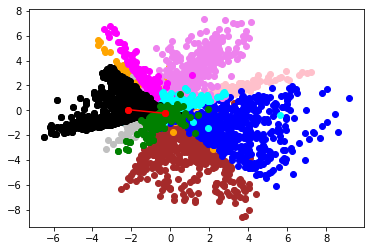

In [23]:
print_embs_with_centers(digits_to_embs, means)

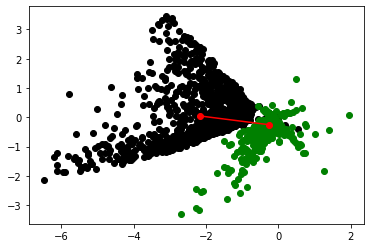

In [24]:
#Чтобы эмбеддинги других цифр не мешали :)
print_two_embs_with_centers(digits_to_embs, means)

Посмотрим на средние (mu) для эмбеддингов

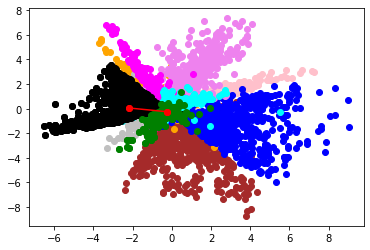

In [25]:
print_embs_with_centers(digits_to_mu, mu_means)

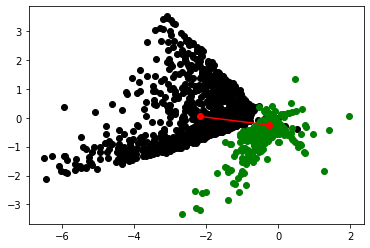

In [26]:
print_two_embs_with_centers(digits_to_mu, mu_means)

***Бейзлайн 2: модель с CNN слоями***

In [27]:
digits_to_embs, digits_to_mu, means, mu_means = get_embs_for_digit(baseline_CNN_VAE_model)

Посмотрим на эмбеддинги

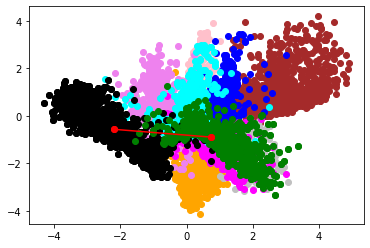

In [28]:
print_embs_with_centers(digits_to_embs, means)

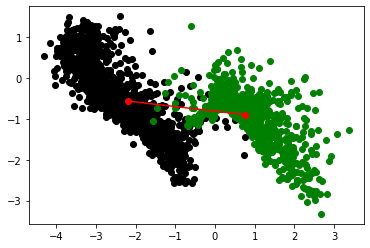

In [29]:
print_two_embs_with_centers(digits_to_embs, means)

Посмотрим на средние (mu) для эмбеддингов

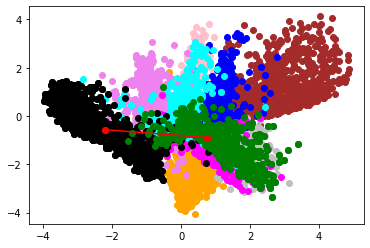

In [30]:
print_embs_with_centers(digits_to_mu, mu_means)

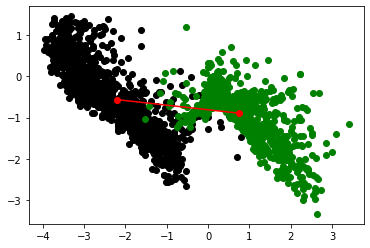

In [31]:
print_two_embs_with_centers(digits_to_mu, mu_means)

***Основная модель***

In [32]:
digits_to_embs, digits_to_mu, means, mu_means = get_embs_for_digit(main_CNN_VAE_model)

Посмотрим на эмбеддинги

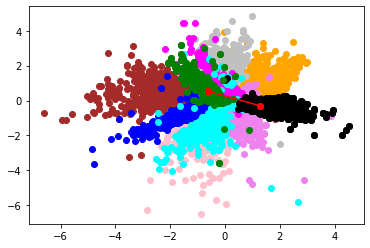

In [33]:
print_embs_with_centers(digits_to_embs, means)

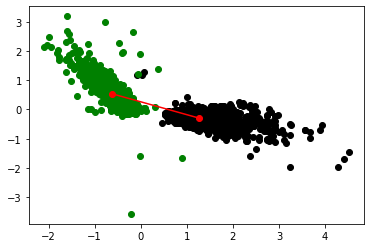

In [34]:
print_two_embs_with_centers(digits_to_embs, means)

Посмотрим на средние (mu) для эмбеддингов

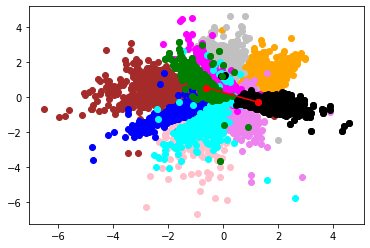

In [35]:
print_embs_with_centers(digits_to_mu, mu_means)

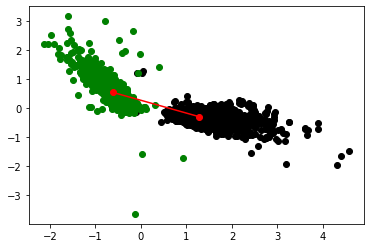

In [36]:
print_two_embs_with_centers(digits_to_mu, mu_means)

В общем и целом, видно, что для моделей с меньшим лоссом эмбеддинги 1 и 5 расходятся (для последней модели они фактически разделены). 

Кроме того, явно проявляется 3 (серый цвет), примерно рядом с 8. А вот 4 и 9 разделяются плохо.